<p style="font-family:	Brush Script MT; color: red; font-size:4em;text-align:center"> Welcome to</p>

# <p style="font-family:Brush Script MT; font-size:4em;text-align:center">⚡MBQLearning⚡ </p> 

In [114]:
using Plots, Random, LinearAlgebra, LightGraphs, GraphPlot, Combinatorics, StatsBase

In [115]:
const ⊗ = kron

kron (generic function with 30 methods)

## Functions on graph states 

In [6]:
#Define Hadamard gate and |+>=H|0> state
H = [1 1; 1 -1]/sqrt(2);
qubit_plus = H*[1,0];

function graph1D(n::Int)
    """
    Creates a 1D graph chain 
    """
    G = SimpleGraph(n)
    for i in 1:n-1
        add_edge!(G, i, i+1);
    end
    G
end

function controlled_z(i::Int,j::Int,n::Int)
    """
    Matrix representation of operator CZij in n qubits
    
    Input: i,j,n
    Output: CZij
    """
    op1, op2 = 1,2
    for k in 1:n
        op1 = op1 ⊗ I(2)
        op2 = k==i || k==j ? op2 ⊗ ([0,1]'⊗[0,1]) : op2 ⊗ I(2)
    end
    op1-op2
end


function swap_ij(i::Int , j::Int, n::Int)
    """
    Matrix representation of operator SWAPij in n qubits
    
    Input: i,j,n
    Output: SWAPij
    """
    op1, op2, op3, op4 = ones(4)
    for k in 1:n
        op1 = k==i || k==j ? op1 ⊗ ([1,0]'⊗[1,0]) : op1 ⊗ I(2)
        op4 = k==i || k==j ? op4 ⊗ ([0,1]'⊗[0,1]) : op4 ⊗ I(2)
        if k==i
            op2, op3 = op2 ⊗ ([1,0]'⊗[0,1]), op3 ⊗ ([0,1]'⊗[1,0]) 
        elseif k==j
            op2, op3 = op2 ⊗ ([0,1]'⊗[1,0]), op3 ⊗ ([1,0]'⊗[0,1]) 
        else
            op2, op3 = op2 ⊗ I(2), op3 ⊗ I(2)
        end
    end
    op1+op2+op3+op4
end

function create_graph_state(G)
    """  
    Input:
    G = graph
    
    Output:
    ψ = Π_{(i,j)∈ G}(CZij)(|+>)^⊗n  
    """
    ψ = 1
    for i in 1:nv(G)
        ψ = ψ⊗qubit_plus
    end
    for e in edges(G)
        ψ=controlled_z(src(e),dst(e),nv(G))*ψ
    end
    ψ
end

function graph_with_input(ψ_in, G)
    """
    Same as create_graph_state but qubit 1 is ψ_in
    (only works with ψ_in pure and single qubit)
    """
    for i in 2:nv(G)
        ψ_in = ψ_in⊗qubit_plus
    end
    for e in edges(G)
        ψ_in=controlled_z(src(e),dst(e),nv(G))*ψ_in
    end
    ψ_in
end
#Pure state to density matrix
pure2density(ψ::Vector) = ψ ⊗ ψ'

#Fidelity between ρ and σ
function fidelity(ρ, σ)
    sρ = sqrt(ρ)
    return abs2(tr(sqrt(sρ*σ*sρ)))
end

function measure_z(graph, ρ, i::Int; fix=false)
    """
    Measures ith qubit of ρ in z basis and updates the graph edges
    """
    n = nv(graph)
    nbh = copy(neighbors(graph, i))
#     for j in nbh
#         graph = rem_edge!(graph, i,j)
#     end
    ρ = ρ isa Vector ? pure2density(ρ) : ρ
    pi_0, pi_1 = 1, 1
    for k in 1:n
        pi_0, pi_1 = k==i ? (pi_0 ⊗ [1 0; 0 0]  , pi_1 ⊗ [0 0; 0 1]) : (pi_0 ⊗ I(2) , pi_1 ⊗ I(2))
    end
    prob0, prob1 =real(tr(ρ*pi_0)), real(tr(ρ*pi_1))
    measurement = sample([0,1], pweights([prob0,prob1]))
    ρ = measurement==0 ? pi_0*ρ*pi_0/prob0 : pi_1*ρ*pi_1/prob1
    
    #fix ρ
    if measurement==1 && fix
        u_fix = 1
        for k in 1:n
            u_fix = k in nbh ? u_fix ⊗ [1 0; 0 -1] : u_fix ⊗ I(2)
        end
        ρ = u_fix*ρ*u_fix'
    end
    return ρ, measurement #,graph
end


function measure_angle(ρ, ϕ, i::Int)
    """
    Measures ith qubit in basis {|0>+exp(iφ)|1>, |0>-exp(iφ)|1>}/sqrt(2)
    
    Input: 
    ρ     = vector representation of ψ
    ϕ     = angle of measurement basis
    i     = measured qubit
    
    Output:
    ρ           = new state after measurement
    measurement = 0 or 1
    """
    ρ = ρ isa Vector ? pure2density(ρ) : ρ
    n = floor(Int,log(2,size(ρ, 1)))
    pi_0, pi_1 = 1, 1
    for k in 1:n
        pi_0, pi_1 = k==i ? (pi_0 ⊗ [1 exp(-im*ϕ); exp(im*ϕ) 1]/2  , pi_1 ⊗ [1 -exp(-im*ϕ);-exp(im*ϕ) 1]/2 ) : (pi_0 ⊗ I(2) , pi_1 ⊗ I(2))
    end
    prob0, prob1 = real(tr(ρ*pi_0)), real(tr(ρ*pi_1))
    measurement = sample([0,1], pweights([prob0,prob1]))
    
    ρ = measurement==0 ? pi_0*ρ*pi_0/prob0 : pi_1*ρ*pi_1/prob1   
    return ρ, measurement
end

function partial_trace(ρ, indices)
    """
    Input:
    ρ       = state
    indices = to be traced
    
    Output
    σ  = Tr_{indices} ρ
    """
    x,y = size(ρ)
    n = floor(Int,log(2,x))
    r = size(indices,1)
    σ = zeros(floor(Int, x/(2^r)), floor(Int,y/(2^r)))
    for m in 1:2^r
        qubits = digits(m, base=2, pad=r)
        ptrace = 1
        for k in 1:n
            if k in indices
                ptrace = qubits[findfirst(x->x==k, indices)]==0 ? ptrace ⊗ [1,0] : ptrace ⊗ [0,1] 
            else
                ptrace = ptrace ⊗ I(2)
            end
        end
        σ += (ptrace')*ρ*ptrace
    end
    return σ
end


function RandomUnitaryMatrix(N::Int)
    """
    Random unitary in N dimensions
    taken from https://discourse.julialang.org/t/how-to-generate-a-random-unitary-matrix-perfectly-in-julia/34102
    """
    x = (rand(N,N) + rand(N,N)*im) / sqrt(2)
    f = qr(x)
    diagR = sign.(real(diag(f.R)))
    diagR[diagR.==0] .= 1
    diagRm = diagm(diagR)
    u = f.Q * diagRm
    return u
end


function apply_byproduct(ρ, sx, sz)
    """
    Input: 
    ρ  = vector/matrix representing quantum state
    sx = vectors of 0s and 1s
    sy = vectors of 0s and 1s
    
    Output: ((σ_x)^⊗sx (σ_z)^⊗sz)ρ((σ_x)^⊗sx (σ_z)^⊗sz)
    """
    ρ = ρ isa Vector ? pure2density(ρ) : ρ
    n = floor(Int,log(2,size(ρ, 1)))
    byprod = 1
    for i in 1:n
        byprod = byprod ⊗ ( ([0 1; 1 0]^(sx[i])) * [1 0; 0 -1]^(sz[i]) )
    end
    return byprod*ρ*byprod'
end


function byproduct_track(info, state)
    """
    info : measurement outcomes
    state: angles
    Tracks byproduct operator
    op = 0 -> Z
    op = 1 -> X
    op = 2 -> Y
    
    returns: sx and sy string
    """
    sx = 0
    sz = 0
    for (ind_i,i) in enumerate(info)
        if i==0
            continue
        elseif i==1
            op = mod(ind_i,2)==0 ? 1 : 0
            for (ind_j,j) in enumerate(state)
                if ind_j>ind_i
                    ac = mod(ind_j,2)==0 ? 1 : 0
                    if j==1
                        continue
                    elseif j==-1
                        if ac!=op
                            op = setdiff!([0,1,2], [op,ac])[1]
                        end
                    end
                end
            end
            if op==0
                sx,sz = sx, mod(sz+1,2)
            elseif op==1
                sx,sz = mod(sx+1,2), sz
            elseif op==2
                sx,sz = mod(sx+1,2), mod(sz+1,2)
            end
        end
    end
    sx, sz
end


byproduct_track (generic function with 1 method)

## RL functions (env, step, reward)

In [7]:
function reward(ρ, σ)
    """
    calculates the reward between two states ρ, σ defined by
    max_{P pauli} F(P*ρ*P, σ)
    """
    rw = 0
    n = floor(Int,log(2,size(ρ, 1)))
    paulix, pauliz = [0 1; 1 0], [1 0; 0 -1]
    for m1 in 1:2^n, m2 in 1:2^n
        str_x = digits(m1, base=2, pad=n)
        str_z = digits(m2, base=2, pad=n)
        opx,opz = 1,1
        for i in 1:n, j in 1:n
            opx = str_x[i]==1 ? opx ⊗ paulix : opx ⊗ I(2)
            opz = str_z[i]==1 ? opz ⊗ pauliz : opz ⊗ I(2)
            rw = max(rw, fidelity(opx*opz*ρ*opz*opx,σ))
        end
    end
    return rw
end

function prepare_env_states(n)
    """
    Prepares observation space:
    Every element is of the form
    [±1,.., ±1, 0, ...,0]
    Where the first i elements are ±1 depending on the outcome of the measurements ϕ_j j∈{1,...,i} and 0 elsewhere
    """
    outcomes = [-1,1]
    states = [zeros(n)]
    for i in 1:n-1
        ll = []
        for st in states[2^(i-1): end]
            cst = copy(st)
            l = []
            for o in outcomes
                new_st = copy(cst)
                new_st[i] = o
                l = isempty(l) ? [new_st] : append!(l, [new_st])
            end
            ll = isempty(ll) ? l : hcat(ll, l)
        end
        states = append!(states, ll)
    end
    states
end


function prepare_env_states2(n)
    """
    Prepares observation space:
    Every element is of the form
    [±1,.., ±1, 0, ...,0 , a_1, ..., a_i, 0, ...,0]
    Where the first i elements are ±1 depending on the outcome of the measurements ϕ_j j∈{1,...,i} and 0 elsewhere
    """
    outcomes = [-1,1]
    actions  = [-1, 1]
    states = [zeros(2*n)]
    for i in 1:n-1
        ll = []
        for st in states[2^(i-1): end]
            cst = copy(st)
            l = []
            for o in outcomes
                for a in actions
                    new_st = copy(cst)
                    new_st[i] = o
                    new_st[n+i] = a
                    l = isempty(l) ? [new_st] : append!(l, [new_st])
                end
            end
            ll = isempty(ll) ? l : hcat(ll, l)
        end
        states = append!(states, ll)
    end
    states
end

#add a label of 3 to avoid confussion (this state space only consists of actions)
prepare_env_states3(n) = prepare_env_states(n)

#eps greedy policy for qtable as dictionary (doesn't work this way I'm not sure why)
eps_greedy_policy(qtable, st; eps=0.1) = rand()>eps ? actions[argmax([qtable[(st,a)] for a in actions]) ] : rand(actions)

#eps greedy policy for qtable as array (more efficient and works 😄)
eps_greedy_policy2(qtable, st; eps=0.1) = rand()>eps ? actions[argmax(qtable[:,st])] : rand(actions)

#some random function that can be ignored (only works when action space is [0, pi/2])
action2angle(action) = action == 0 ? 0.0 : -pi/2

#need to use this for geting the index of an observation of the q table (can be ignored)
state_indx_f(states) = Dict(st => indx for (indx,st) in enumerate(states));

function step(state_in, ρ, σ, action, n; info = [])
    """
    Takes step in the environment
    Input:
    state_in = [±1,...,±1,0,...0, ...,0] length n
    ρ = density matrix of quantum state of dimension n x n
    σ = dm of state we want to achieve (for now dimension 2x2)
    action = some measurement basis
    n = # of qubits
    """
    state = copy(state_in)
    rw, done = 0, false
    ith_qubit = isnothing(findlast(state.!=0)) ? 1 : findlast(state.!=0) + 1
    ρ , measurement = measure_angle(ρ, action2angle(action), ith_qubit)
    state[ith_qubit] = (-1.0)^(measurement+1)
    if ith_qubit + 1 == n
        done = true
        ρ = partial_trace(ρ, 1:n-1)
        rw = reward(ρ,σ) 
    end 
    return state, ρ, rw, done, info
end


function step2(state_in, ρ, σ, action, n; info = [])
    """
    Takes step in the environment (with prepare_env_states2)
    same as step function (previous) but the state are of length 2n (measurements + actions)
    """
    state = copy(state_in)
    rw, done = 0, false
    ith_qubit = isnothing(findfirst(state.==0)) ? n : findfirst(state.==0) 
    ρ , measurement = measure_angle(ρ, action2angle(action), ith_qubit)
    state[ith_qubit] = (-1.0)^(measurement+1)
    state[ith_qubit+n] = (-1.0)^(action)
    if ith_qubit + 1 == n
        done = true
        ρ = partial_trace(ρ, 1:n-1)
        rw = reward(ρ,σ) 
        #rw = fidelity(ρ,σ)
    end 
    return state, ρ, rw, done, info
end


function step3(state_in, ρ, σ, action, n; info = [], rw_fidel=false)
    """
    Takes step in the environment (with prepare_env_states3)
    same as step function 1 but the state are actions, and we now implement byproduct op
    
    state[i] = -1 means action was pi/2
    state[i] = 1 means action was 0
    """
    state = copy(state_in)
    rw, done = 0, false
    ith_qubit = isnothing(findfirst(state.==0)) ? n : findfirst(state.==0) 
    ρ , measurement = measure_angle(ρ, action2angle(action), ith_qubit)
    state[ith_qubit] = (-1.0)^(action)
    append!(info, measurement)
    if ith_qubit + 1 == n
        done = true
        ρ = partial_trace(ρ, 1:n-1)
        #rw = reward(ρ,σ) 
#         sx = info[1] + info[3] + info[4]
#         sz = info[2] + info[3]
        sx,sz = byproduct_track(info, state)
        
        if !rw_fidel
            rw = isapprox(fidelity(apply_byproduct(ρ, sx, sz),σ), 1, rtol=0.001) ? 1 : -1 
        elseif rw_fidel
            rw = (fidelity(apply_byproduct(ρ, sx, sz),σ))
        end
    end 
    return state, ρ, rw, done, info
end


step3 (generic function with 1 method)

In [8]:
function q_learning(episodes, n, states, actions, unitary; γ=0.98, ϵ=0.1, q_table = nothing, batch=100, ρ_in = nothing, σ = nothing, sarsa = false, α = 0.3, rw_fidel = false)
    """
    Implements q learning on the defined environment
    Input:
    episodes = # of episodes
    n        = # of qubits
    states   = observation space
    actions  = action space
    unitary  = the unitary gate that we want to learn
    γ        = discount factor
    eps      = for eps greedy policy
    q_table  = for using a predefined q_table
    batch    = num(ber of runs per episode (normally 1 but why not 100)
    ρ_in, σ  = for deterministic reset, if they are nothing a ψ_in will be randomly generated
    sarsa    = bool to use SARSA or Q-learning
    
    Output:
    q_table  = Q value for every (state, action) pair
    final_rewards = average reward per batch for every episode
    maxs = max reward per batch for every episode
    mins = min reward per batch for every episode
    """
    
    #generates random state if randST is true
    randST = isnothing(ρ_in)
    if randST
        ψ = RandomUnitaryMatrix(2)*[1,0]
        σ = unitary*(ψ⊗ψ')*(unitary')    
        ρ_in =pure2density(graph_with_input(ψ, G))
    end
    ρ, rw, state, done, info = copy(ρ_in), 0, zeros(n), false, []
    
    #q_table = isnothing(q_table) ? Dict((st, act) => rand() for st in states, act in actions) : q_table
    
    #generates q table
    q_table = isnothing(q_table) ? rand(size(actions)[1], size(states)[1]) : q_table
    state_indx = state_indx_f(states)
    final_rewards = []
    maxs, mins = [],[]
    
    qbef = copy(q_table)
    
    #runs over episodes
    for eps in 1:episodes
        IJulia.clear_output(true)
        println("Episode: ", eps)
        println("Total change of Q-table: ", sum(abs.(q_table-qbef)))
        println("Q-values for state zeros(n): ", q_table[:, state_indx[zeros(n)]])
        qbef = copy(q_table)
        
        tot_rw = 0
        maxrw, minrw = -1.0, 1.0
        for j in 1:batch
            while !done
                #act = eps_greedy_policy(q_table, state)
                #println("state " ,state)
                #println(q_table[:,state_indx[state]])
                act = eps_greedy_policy2(q_table, state_indx[state]; eps=ϵ)
                state_new, ρ_new, rw, done, info = step3(state, ρ, σ, act, n, info=info, rw_fidel=rw_fidel)
                #q_table[(state, act)] = rw + γ*maximum([q_table[(state_new, a)] for a in actions])
                if !done
                    if sarsa
                        act2 = eps_greedy_policy2(q_table, state_indx[state_new], eps=ϵ)
                        q_table[act+1, state_indx[state]] = (1-α)*q_table[act+1, state_indx[state]] + α*(rw + γ*q_table[act2+1, state_indx[state_new]])
                    else
                        q_table[act+1, state_indx[state]] = (1-α)*q_table[act+1, state_indx[state]] + α*(rw + γ*maximum(q_table[:, state_indx[state_new]]))
                    end
                elseif done
                    q_table[act+1, state_indx[state]] = rw
                end
                state=state_new
                ρ=ρ_new
            end
            tot_rw += rw
            maxrw = maximum([maxrw, rw])
            minrw = minimum([minrw, rw])
            if randST
                ψ = RandomUnitaryMatrix(2)*[1,0]
                σ = unitary*(ψ⊗ψ')*unitary'   
                ρ_in =pure2density(graph_with_input(ψ, G))
            end
            ρ, rw, state, done, info = copy(ρ_in), 0, zeros(n), false, []
        end
        #saves the average over the batch size, max reward in the batch and min reward in the batch
        final_rewards =  append!(final_rewards, tot_rw/batch)
        maxs = append!(maxs, maxrw)
        mins = append!(mins, minrw)
    end
    return q_table, (final_rewards, maxs, mins)
end

q_learning (generic function with 1 method)

# Let's check that the functions work for implementing basic gates

## Hadamard

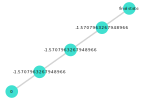

In [9]:
n=5
G = SimpleGraph(n)
add_edge!(G, 1, 2);
add_edge!(G, 2, 3);
add_edge!(G, 3, 4);
add_edge!(G, 4, 5);

angles = [0, -pi/2, -pi/2, -pi/2, "final state"]
gplot(G, nodelabel=angles)

In [10]:
#prepares initial state
ψ_input = RandomUnitaryMatrix(2)*[1, 0];
ψ_in = graph_with_input(ψ_input, G)
ψ_in = pure2density(ψ_in);

In [11]:
#Measures X_1 Y_2 Y_3 Y_4 and applies byproduct operator
angles = [0, pi/2, pi/2, pi/2, "state"]
state, s1 = measure_angle(ψ_in, angles[1], 1)
state, s2 = measure_angle(state, angles[2], 2)
state, s3 = measure_angle(state, angles[3], 3)
state, s4 = measure_angle(state, angles[4], 4)
state = partial_trace(state, [1,2,3,4])
#state = apply_byproduct(state, mod(s1+s3+s4,2), mod(s2+s3,2) )
sx,sz = byproduct_track([s1, s2, s3, s4], [1, -1, -1, -1])
state = apply_byproduct(state, sx, sz )
ψ_out = map(x->round(x, digits=3 ),state)

#Check fidelity
fidelity(ψ_out, H*pure2density(ψ_input)*H)

0.9998818863579443

### RL for Hadamard

In [556]:
#define action space and observation space
actions = [0, 1];
states = prepare_env_states3(5);

In [584]:
#runs table q_learning for this problem with random ψ_in
rw_fidel = true
q_table_1, rews  = q_learning(200, n, states, actions, H, γ=1, ϵ=0.01, batch = 10, α=0.1, rw_fidel = rw_fidel);

Episode: 200
Total change of Q-table: 1.0481432610731645e-8
Q-values for state zeros(n): [0.5662504104767495, 1.0000000066198498]


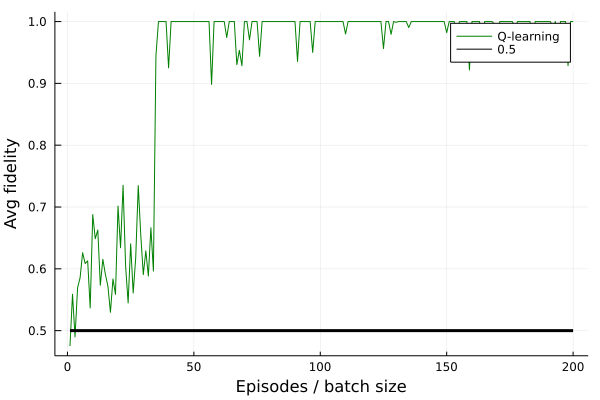

In [585]:
#plots average reward
plot(1:size(rews[1])[1], rews[1], color=:green, linewidth=1, label="Q-learning")
if rw_fidel
    plot!(1:size(rews[1])[1], 0.5*ones(size(rews[1])[1]), color=:black, linewidth=3, label="0.5")
    ylabel!("Avg fidelity")
elseif !rw_fidel
    plot!(1:size(rews[1])[1], zeros(size(rews[1])[1]), color=:black, linewidth=3, label="0")
    ylabel!("Avg reward")
end
xlabel!("Episodes / batch size")


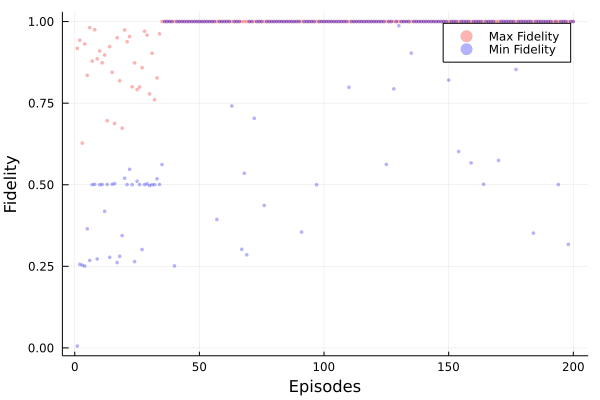

In [586]:
scatter(1:size(rews[2])[1], rews[2], color=:red, label = "Max Fidelity", ms=2,msw=0.1, alpha=0.3)
scatter!(1:size(rews[3])[1], rews[3], color=:blue, label = "Min Fidelity",ms=2, msw=0.1, alpha=0.3)
xlabel!("Episodes")
ylabel!("Fidelity")

In [562]:
ψ = RandomUnitaryMatrix(2)*[1,0];
σ = H*(ψ⊗ψ')*H    
ρ_in =pure2density(graph_with_input(ψ, G))
ρ, rw, state, done = copy(ρ_in), 0, zeros(n), false

state, ρ, rw, done, info = step3(state, ρ, σ, 1, n)
state, ρ, rw, done, info = step3(state, ρ, σ, 1, n, info=info)
state, ρ, rw, done, info = step3(state, ρ, σ, 1, n, info=info)
state, ρ, rw, done, info = step3(state, ρ, σ, 0, n, info=info)
rw

1

#### Let us check what the q-table suggests to perform a Hadamard gate:

greedy actions: Any[-1.5707963267948966, -1.5707963267948966, -1.5707963267948966, 0.0, "final"]

Reward 1

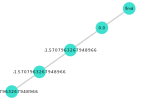

In [561]:
greedy_actions = []
ψ_input = RandomUnitaryMatrix(2)*[1,0]
ρ =pure2density(graph_with_input(ψ_input, G))
σ = pure2density(H*ψ_input);

state = zeros(n)
info = []
done = false
rw = 0
while !done
    action = eps_greedy_policy2(q_table_1,state_indx[state], eps=0)
    append!(greedy_actions,action2angle(action)) 
    state_n, ρ, rw, done, info = step3(state, ρ, σ, action, n, info=info)
    state = state_n
end
append!(greedy_actions, ["final"])
println("greedy actions: ", greedy_actions)
print("\nReward ", rw)

gplot(G, nodelabel=greedy_actions)

## $\pi/2$-phase gate

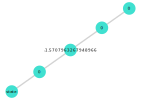

In [140]:
#It also implements the π/2 phase gate
n=5
G = SimpleGraph(n)
add_edge!(G, 1, 2);
add_edge!(G, 2, 3);
add_edge!(G, 3, 4);
add_edge!(G, 4, 5);

angles = [0, 0, -pi/2, 0, "state"]
gplot(G, nodelabel=angles)

In [141]:
ψ_input = RandomUnitaryMatrix(2)*[1,0];
ψ_in = graph_with_input(ψ_input, G)
ψ_in = pure2density(ψ_in);
pz = [1 0; 0 im]
σ = pure2density(pz*ψ_input);

state, s1 = measure_angle(ψ_in, 0, 1)
state, s2 = measure_angle(state, 0, 2)
state, s3 = measure_angle(state, -pi/2, 3)
state, s4 = measure_angle(state, 0, 4)
state = partial_trace(state, [1,2,3,4])
#state = apply_byproduct(state, mod(s2+s4,2), mod(s1+s2+s3+1,2))
sx, sz = byproduct_track([s1, s2, s3, s4], [1, 1,-1,1,0])
state = apply_byproduct(state, sx, sz)

fidelity(state,σ)

1.0000000077657152

In [598]:
#runs table q_learning for this problem with random ψ_in
rw_fidel = true
q_table_2, rews  = q_learning(200, n, states, actions,pz, γ=1, ϵ=0.01, batch = 10, α=0.1, rw_fidel=rw_fidel);

Episode: 200
Total change of Q-table: 0.05138255289534366
Q-values for state zeros(n): [0.5069837736547408, 1.0000000079226605]


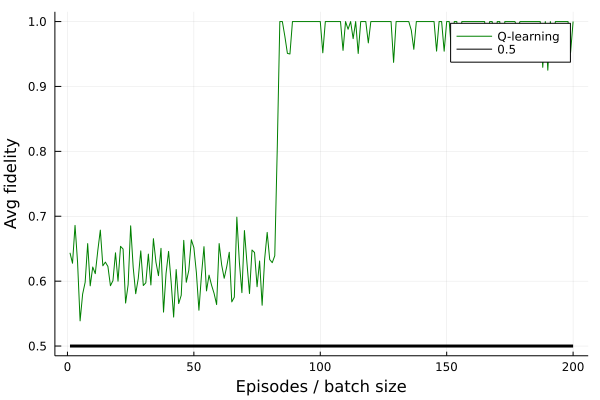

In [599]:
#plots average reward
plot(1:size(rews[1])[1], rews[1], color=:green, linewidth=1, label="Q-learning")
if rw_fidel
    plot!(1:size(rews[1])[1], 0.5*ones(size(rews[1])[1]), color=:black, linewidth=3, label="0.5")
    ylabel!("Avg fidelity")
elseif !rw_fidel
    plot!(1:size(rews[1])[1], zeros(size(rews[1])[1]), color=:black, linewidth=3, label="0")
    ylabel!("Avg reward")
end
xlabel!("Episodes / batch size")

#### Let us check what the q-table suggests to perform a phase gate:

greedy actions: Any[-1.5707963267948966, 0.0, 0.0, 0.0, "final"]

Reward 1

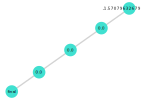

In [600]:
state_indx = state_indx_f(states)

greedy_actions = []
ψ_input = RandomUnitaryMatrix(2)*[1,0]
ρ =pure2density(graph_with_input(ψ_input, G))
σ = pure2density(pz*ψ_input);

state = zeros(n)
info = []
done = false
rw = 0
while !done
    action = eps_greedy_policy2(q_table_2,state_indx[state], eps=0)
    append!(greedy_actions,action2angle(action)) 
    state_n, ρ, rw, done, info = step3(state, ρ, σ, action, n, info=info)
    state = state_n
end
append!(greedy_actions, ["final"])
println("greedy actions: ", greedy_actions)
print("\nReward ", rw)

gplot(G, nodelabel=greedy_actions)

In [583]:
q_table_2[:, state_indx[zeros(5)]]
#q_table_2[:, state_indx[ [-1, 1, 1, 1, 0]]]

2-element Vector{Float64}:
 1.0000000078274336
 0.5817415695131164

In [580]:
ψ = [1,1]/sqrt(2);
σ = pure2density(pz*ψ)  
ρ_in =pure2density(graph_with_input(ψ, G))
ρ, rw, state, done = copy(ρ_in), 0, zeros(n), false

state, ρ, rw, done, info = step3(state, ρ, σ, 1, n)
state, ρ, rw, done, info = step3(state, ρ, σ, 0, n, info=info)
state, ρ, rw, done, info = step3(state, ρ, σ, 0, n, info=info)
state, ρ, rw, done, info = step3(state, ρ, σ, 0, n, info=info)
ρ
rw

1

In [34]:
ψ_in1 = RandomUnitaryMatrix(2)*[1,0]
ψ_in2 = RandomUnitaryMatrix(2)*[1,0]
ψ_in3 = RandomUnitaryMatrix(2)*[1,0]
fidelity(swap_ij(1,3,3)*(pure2density(ψ_in1 ⊗ ψ_in2 ⊗ ψ_in3))*swap_ij(1,3,3), pure2density(ψ_in3⊗ψ_in2⊗ψ_in1))

1.0000000419343658

## 2D state functions!

In [132]:
function graph_with_multiple_inputs(G ; inputs=[], indices=[])
    """
    Returns pure graph state with pure multiple inputs
    """
    @assert size(inputs)==size(indices)
    ψ = 1
    if isempty(inputs)
        ψ = create_graph_state(G) 
    elseif !isempty(inputs)
        for i in 1:nv(G)
            st = i in indices ? inputs[findfirst(x->x==i, indices)] : qubit_plus
            ψ = ψ ⊗ st
        end
        for e in edges(G)
            ψ=controlled_z(src(e),dst(e),nv(G))*ψ
        end 
    end
    ψ
end

function cz_after_layer_measurement(ρ, n::Int)
    """
    Applies cz_{i,i+1} to every qubit
    """
    if n>1
        for i in 1:n-1
            controll = controlled_z(i, i+1, n)
            ρ = controll*ρ*(controll')
        end
    end
    ρ
end

function measure_angle_2d_intermediate(ρ, ϕ, i::Int, n::Int)
    ρ = ρ ⊗ pure2density(qubit_plus)
    controll_ilast = controlled_z(i, n+1, n+1)
    ρ = controll_ilast*ρ*(controll_ilast')
    ρ, outcome = measure_angle(ρ, ϕ, i)
    swap_ilast = swap_ij(i, n+1,n+1)
    ρ = swap_ilast*ρ*(swap_ilast')
    ρ = partial_trace(ρ, [n+1])
    return ρ, outcome
end

function measure_z_2d_intermediate(ρ, i::Int, n::Int)
    graph = graph1D(n)
    add_vertex!(graph)
    add_edge!(graph, i, n+1)
    ρ = ρ ⊗ pure2density(qubit_plus)
    controll_ilast = controlled_z(i, n+1, n+1)
    ρ = controll_ilast*ρ*(controll_ilast')
    ρ, outcome = measure_z(graph, ρ, i::Int; fix=true)
    swap_ilast = swap_ij(i, n+1,n+1)
    ρ = swap_ilast*ρ*(swap_ilast')
    ρ = partial_trace(ρ, [n+1])
    return ρ, outcome
end

function layer_measurement(ρ, ϕ, i::Int, n::Int, last_layer)
    if !last_layer
        ρ, outcome = ϕ ==-1 ? measure_z_2d_intermediate(ρ, i, n) : measure_angle_2d_intermediate(ρ, ϕ, i, n)
    elseif last_layer
        if ϕ==-1
            graph=graph1D(n)
            ρ, outcome = measure_z(graph, ρ, i::Int; fix=true)
        else
            ρ, outcome = measure_angle(ρ, ϕ, i)
        end
    end
    return ρ, outcome
end

function cnot_ij(i::Int , j::Int, n::Int)
    """
    Matrix representation of operator CNOTij in n qubits
    
    Input: i,j,n
    Output: CNOTij
    """
    op1, op2, op3, op4 = ones(4)
    for k in 1:n
        op1 = k==i || k==j ? op1 ⊗ ([1,0]'⊗[1,0]) : op1 ⊗ I(2)
        if k==i
            op2, op3, op4 =op2 ⊗ ([1,0]'⊗[1,0]) , op3 ⊗ ([0,1]'⊗[0,1]), op4 ⊗ ([0,1]'⊗[0,1]) 
        elseif k==j
            op2, op3, op4 =op2 ⊗ ([0,1]'⊗[0,1]) ,op3 ⊗ ([1,0]'⊗[0,1]), op4 ⊗ ([0,1]'⊗[1,0]) 
        else
            op2, op3, op4 = op2 ⊗ I(2), op3 ⊗ I(2), op4 ⊗ I(2)
        end
    end
    op1+op2+op3+op4
end

cnot_ij (generic function with 1 method)

### Check that 2d functions work to implement hadamard and π/2 phase 😄

In [149]:
ψ_in1 = RandomUnitaryMatrix(2)*[0,1] 

width, length = 1, 5
G = graph1D(1)
ρ = pure2density(graph_with_multiple_inputs(G, inputs = [ψ_in1], indices=[1]));

ρ, s1 = layer_measurement(ρ, 0, 1, 1, false)
ρ  = cz_after_layer_measurement(ρ,1) #this last function doesn't do anything in the 1D case, I still put it for clarity.

ρ, s2 = layer_measurement(ρ, -pi/2, 1, 1, false)
ρ  = cz_after_layer_measurement(ρ,1) #same here

ρ, s3 = layer_measurement(ρ, -pi/2, 1, 1, false)
ρ  = cz_after_layer_measurement(ρ,1) #same here

ρ, s4 = layer_measurement(ρ, -pi/2, 1, 1, false)
ρ  = cz_after_layer_measurement(ρ,1) #same here

sx,sz =  byproduct_track([s1,s2,s3,s4], [1,-1,-1,-1,0])
println("Is the outcome state Hψᵢₙ? ", apply_byproduct(ρ, sx,sz) ≈ pure2density(H*ψ_in1))

Is the outcome state Hψᵢₙ? true


In [150]:
ψ_in1 = RandomUnitaryMatrix(2)*[0,1] 

width, length = 1, 5
G = graph1D(1)
ρ = pure2density(graph_with_multiple_inputs(G, inputs = [ψ_in1], indices=[1]));

ρ, s1 = layer_measurement(ρ, 0, 1, 1, false)
ρ  = cz_after_layer_measurement(ρ,1)

ρ, s2 = layer_measurement(ρ, 0, 1, 1, false)
ρ  = cz_after_layer_measurement(ρ,1)

ρ, s3 = layer_measurement(ρ, -pi/2, 1, 1, false)
ρ  = cz_after_layer_measurement(ρ,1)

ρ, s4 = layer_measurement(ρ, 0, 1, 1, false)
ρ  = cz_after_layer_measurement(ρ,1)

sx,sz =  byproduct_track([s1,s2,s3,s4], [1,1,-1,1,0]) 
println("Is the outcome state RZ(-π/2)ψᵢₙ? ", apply_byproduct(ρ, sx,sz) ≈ pure2density(pz*ψ_in1))

Is the outcome state RZ(-π/2)ψᵢₙ? true


## CNOT

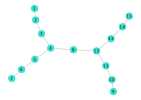

In [135]:
n=15
G = SimpleGraph(n)
add_edge!(G, 1, 2);
add_edge!(G, 2, 3);
add_edge!(G, 3, 4);
add_edge!(G, 4, 5);
add_edge!(G, 5, 6);
add_edge!(G, 6, 7);
add_edge!(G, 4, 8);
add_edge!(G, 9, 10);
add_edge!(G, 10, 11);
add_edge!(G, 11, 12);
add_edge!(G, 8, 12);
add_edge!(G, 12, 13);
add_edge!(G, 13, 14);
add_edge!(G, 14, 15);

gplot(G, nodelabel=1:nv(G))

In [136]:
ψ_in1 = [0,1]
ψ_in2 = [1,0]

2-element Vector{Int64}:
 1
 0

In [106]:
ρ = pure2density(graph_with_multiple_inputs(graph1D(2), inputs = [ψ_in1, ψ_in2], indices=[1,2]));
ρ

4×4 Matrix{Int64}:
 0  0  0  0
 0  0  0  0
 0  0  1  0
 0  0  0  0

In [107]:
width, length = 3, 7
G = graph1D(3)
ρ = pure2density(graph_with_multiple_inputs(G, inputs = [ψ_in1, ψ_in2], indices=[1,3]));

# table = [0 1 1 1 1 ]

# for l in 1:length-1
#     for w in 1:width-1
        
#     end
#     ρ = cz_after_layer_measurement(ρ, width)
# end

In [108]:
ρ, s1 = layer_measurement(ρ, 0, 1, 3, false)
ρ, _ = layer_measurement(ρ, -1, 2, 3, false)
ρ, s9 = layer_measurement(ρ, 0, 3, 3, false)
ρ  = cz_after_layer_measurement(ρ,3)

ρ, s2 = layer_measurement(ρ, pi/2, 1, 3, false)
ρ, _ = layer_measurement(ρ, -1, 2, 3, false)
ρ, s10 = layer_measurement(ρ, 0, 3, 3, false)
ρ  = cz_after_layer_measurement(ρ,3)

ρ, s3 = layer_measurement(ρ, pi/2, 1, 3, false)
ρ, _ = layer_measurement(ρ, -1, 2, 3, false)
ρ, s11 = layer_measurement(ρ, 0, 3, 3, false)
ρ  = cz_after_layer_measurement(ρ,3)

ρ, s4 = layer_measurement(ρ, pi/2, 1, 3, false)
ρ, s8 = layer_measurement(ρ, pi/2, 2, 3, false)
ρ, s12 = layer_measurement(ρ, pi/2, 3, 3, false)
ρ  = cz_after_layer_measurement(ρ,3)

ρ, s5 = layer_measurement(ρ, pi/2, 1, 3, false)
ρ, _ = layer_measurement(ρ, -1, 2, 3, false)
ρ, s13 = layer_measurement(ρ, 0, 3, 3, false)
ρ  = cz_after_layer_measurement(ρ,3)

ρ, s6 = layer_measurement(ρ, pi/2, 1, 3, false)
ρ, _ = layer_measurement(ρ, -1, 2, 3, false)
ρ, s14 = layer_measurement(ρ, 0, 3, 3, false)
ρ  = cz_after_layer_measurement(ρ,3)

ρ, _ = layer_measurement(ρ, -1, 2, 3, true)
ρ = partial_trace(ρ, 2)

sx = [mod(s2+s3+s5+s6,2), mod(s2+s3+s8+s10+s12+s14,2)]
sz = [mod(s1+s3+s4+s5+s8+s9+s11+1,2), mod(s9+s11+s13,2)]
ρ = map(x->round(x, digits=4 ), apply_byproduct(ρ, sx,sz))

4×4 Matrix{ComplexF64}:
  1.0-0.0im   0.0-0.0im   0.0-0.0im   0.0-0.0im
  0.0+0.0im  -0.0-0.0im  -0.0-0.0im  -0.0-0.0im
  0.0+0.0im   0.0+0.0im   0.0+0.0im   0.0+0.0im
 -0.0+0.0im  -0.0-0.0im  -0.0+0.0im  -0.0+0.0im

In [109]:
cnot_ij(1,2,2)*pure2density(ψ_in1 ⊗ ψ_in2)*cnot_ij(1,2,2)

4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0

## Cluster state

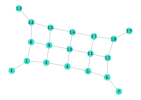

In [602]:
n=19
G = SimpleGraph(n)
add_edge!(G, 1, 2);
add_edge!(G, 2, 3);
add_edge!(G, 3, 4);
add_edge!(G, 4, 5);
add_edge!(G, 5, 6);
add_edge!(G, 6, 7);
add_edge!(G, 2, 8);
add_edge!(G, 3, 9);
add_edge!(G, 8, 9);
add_edge!(G, 4, 10);
add_edge!(G, 9, 10);
add_edge!(G, 5, 11);
add_edge!(G, 10, 11);
add_edge!(G, 6, 12);
add_edge!(G, 11,12);
add_edge!(G, 13,14);
add_edge!(G, 8, 14);
add_edge!(G, 14,15);
add_edge!(G, 9,15);
add_edge!(G, 15,16);
add_edge!(G, 16,17);
add_edge!(G, 17,18);
add_edge!(G, 18,19);
add_edge!(G, 10,16);
add_edge!(G, 11,17);
add_edge!(G, 12,18);

gplot(G, nodelabel=1:nv(G))